<h2>Hue Entropy Calculation Class</h2>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import colorsys
from scipy.ndimage import gaussian_filter1d, maximum_filter1d
from scipy.signal import medfilt
import itertools
import os
import shutil
import math
import datetime
from scipy import ndimage

class Food:
    def __init__(self, Img):
        self.img = Img.copy()
        
        tmp = cv2.cvtColor(Img, cv2.COLOR_RGB2HSV)
        
        self.img_h, self.img_S, self.img_I = cv2.split(tmp)
        
        self.entropy_img = None
        self.entropy_img_full = None
        self.entropy = None
        self.kernel_ratio = tuple()
        self.kernel_size = tuple()
        self.unit = 1
        self.minmax = None
        self.std = None
        
    def show_src_img(self, title):
        plt.imshow(self.img)
        plt.title('Src: ' + str(title))
        plt.show()
    
    def getImg(self):
        return self.IMG
    
    def hue_suppression_(self, unit = 5):
        self.unit = unit
        for i in range(self.img_h.shape[0]):
            for j in range(self.img_h.shape[1]):
                self.img_h[i, j] = self.img_h[i, j] - self.img_h[i, j] % self.unit
    
    def hue_suppression(self, unit = 5):
        self.img_h = ndimage.median_filter(self.img_h, size=5)
                
    def run_entropys(self):
        entropy_lst = []
        for kernel_ratio in [(0.2, 0.2), (0.25, 0.25), (0.3, 0.3)]:
            entropy_img = np.zeros((self.img.shape[0], self.img.shape[1]))
            img_h = self.img_h

            kernel_x = (int)(img_h.shape[1] * kernel_ratio[0])
            if kernel_x % 2 == 0:
                kernel_x = kernel_x + 1
            kernel_y = (int)(img_h.shape[0] * kernel_ratio[1])
            if kernel_y % 2 == 0:
                kernel_y = kernel_y + 1

            self.kernel_ratio = kernel_ratio
            self.kernel_size = tuple([kernel_x, kernel_y])


            nHalf_x = kernel_x // 2
            nHalf_y = kernel_y // 2

            left, right = nHalf_x, img_h.shape[1] - nHalf_x - 1
            top, bottom = nHalf_y, img_h.shape[0] - nHalf_y - 1

            for i in range(0, img_h.shape[1]):
                for j in range(0, img_h.shape[0]):
                    if i < left:
                        i1 = left
                    else:
                        i1 = i

                    if i  > right:
                        i2 = right
                    else:
                        i2 = i

                    if j < top:
                        j1 = top
                    else:
                        j1 = j

                    if j > bottom:
                        j2 = bottom
                    else:
                        j2 = j

                    hist = cv2.calcHist([img_h[j1 - nHalf_y:j2 + nHalf_y, i1 - nHalf_x:i2 + nHalf_x]], [0], None, [360], [0, 359])
                    hist_norm = hist.ravel() / hist.sum()
                    #hist_norm = np.where(hist_norm != 0, hist_norm * np.log2(hist_norm), 0)
                    hist_norm = hist_norm[np.nonzero(hist_norm)]
                    #entropy = -hist_norm.sum()
                    entropy = -np.sum(hist_norm * np.log2(hist_norm))
                    #print(entropy)

                    entropy_img[j, i] = entropy
                    #print(self.entropy[j, i])
                    
            entropy_lst.append(entropy_img)
                
        #for img in entropy_lst:
        #        print(np.min(img), np.max(img))
        
        res = np.mean(np.array([img for img in entropy_lst]), axis=0)
        self.entropy = res.copy()
        
        self.entropy = cv2.GaussianBlur(self.entropy, (5,5), 0)
        
        self.entropy_img = self.entropy.copy()
        
        #max_entropy = math.log(kernel_x*kernel_y)
        #max_entropy = np.log2(kernel_x*kernel_y)
        #print(max_entropy)
        max_entropy = np.max(self.entropy_img)
        self.entropy_img = (self.entropy_img / max_entropy) * 255
        self.entropy_img = self.entropy_img.astype(np.uint8)
        
        self.entropy_img_full = self.entropy_img.copy()
        #self.entropy_img = self.entropy_img[top:bottom, left:right]
        #self.entropy = self.entropy[top:bottom, left:right]
        self.kernel = 'Mixed'
        
        self.minmax = np.round(np.max(self.entropy) - np.min(self.entropy), 3)
        self.std = np.std(self.entropy.ravel())
                
    
    def run_entropy(self, kernel_ratio=(0.1, 0.1)):
        self.entropy = np.zeros((self.img.shape[0],self.img.shape[1]))
        img_h = self.img_h
        
        kernel_x = (int)(img_h.shape[1] * kernel_ratio[0])
        if kernel_x % 2 == 0:
            kernel_x = kernel_x + 1
        kernel_y = (int)(img_h.shape[0] * kernel_ratio[1])
        if kernel_y % 2 == 0:
            kernel_y = kernel_y + 1
            
        self.kernel_ratio = kernel_ratio
        self.kernel_size = tuple([kernel_x, kernel_y])
            
        
        nHalf_x = kernel_x // 2
        nHalf_y = kernel_y // 2
        
        left, right = nHalf_x, img_h.shape[1] - nHalf_x - 1
        top, bottom = nHalf_y, img_h.shape[0] - nHalf_y - 1
        
        
        sigma = 3
        # 1차원 가우시안 커널 생성
        kx = cv2.getGaussianKernel(self.kernel_size[0], sigma)
        ky = cv2.getGaussianKernel(self.kernel_size[1], sigma)

        # 2차원 가우시안 커널 생성
        kw = np.outer(kx, ky)
        
        for i in range(0, img_h.shape[1]):
            for j in range(0, img_h.shape[0]):
                if i < left:
                    i1 = left
                else:
                    i1 = i
                    
                if i  > right:
                    i2 = right
                else:
                    i2 = i
                    
                if j < top:
                    j1 = top
                else:
                    j1 = j
                    
                if j > bottom:
                    j2 = bottom
                else:
                    j2 = j
                    
                hist = cv2.calcHist([img_h[j1 - nHalf_y:j2 + nHalf_y, i1 - nHalf_x:i2 + nHalf_x]], [0], None, [360], [0, 359])
                #todo gaussian weight
                #img_window = img_h[j1 - nHalf_y:j2 + nHalf_y, i1 - nHalf_x:i2 + nHalf_x]
                #kw_window = kw[ - nHalf]
                #hist = [0 for _ in range(360)]
                #for j in range(j1 + j2):
                #    for i in range(i1 + i2):
                #        hist[img_h[j,i]] = hist[img_h[j, i]] + kw[]
                
                
                hist_norm = hist.ravel() / hist.sum()
                hist_norm = hist_norm[np.nonzero(hist_norm)]
                entropy = -np.sum(hist_norm * np.log2(hist_norm))
                
                self.entropy[j, i] = entropy
                
        self.entropy_img = self.entropy.copy()
        
        max_entropy = np.max(self.entropy_img)
        self.entropy_img = (self.entropy_img / max_entropy) * 255
        self.entropy_img = self.entropy_img.astype(np.uint8)
        
        self.entropy_img_full = self.entropy_img.copy()
        self.kernel = (kernel_x, kernel_y)
        
                        
    def show_entropy(self, title):
        plt.imshow(self.entropy_img, cmap='gray')
        msg1 = '\nHue suppresion unit: ' + str(self.unit) + '\nkernel ratio, size: ' + str(self.kernel_ratio) + ', ' + str(self.kernel_size)
        msg2 = '\nmin, max entropy : ' + str(np.min(self.entropy)) + ', ' + str(np.max(self.entropy))
        plt.title(str(title) + msg1 + msg2)
        plt.show()
        
    def run_entropy_otsu(self):
        t, t_img = cv2.threshold(np.uint8(self.entropy_img), -1, 255,  cv2.THRESH_BINARY | cv2.THRESH_OTSU) 
        
        plt.imshow(t_img, cmap='gray')
        
    def show_entropy_plot(self, title):
        tmp = self.entropy.ravel()
        tmp.sort()
        plt.plot(tmp)
        plt.title('Entropy Plot: ' + str(title))
        plt.show()
        
    def get_entropy_img(self):
        return self.entropy_img
    
    def show_hue_img(self,title):
        plt.imshow(self.img_h, cmap='gray')
        plt.title('Hue: ' + str(title))
        plt.show()
        
    def show_overlayed(self, title, ratio=(0.3, 0.7)):
        dst = cv2.addWeighted(self.img, ratio[0], cv2.cvtColor(self.entropy_img_full, cv2.COLOR_GRAY2RGB), ratio[1], 0)
        plt.imshow(dst)
        plt.title('Overlapped: ' + str(title));
        plt.show()

<h2>Overall System Class</h2>

In [2]:
class MixtureSystem:
    def __init__(self, root, tol=1.02):
        self.threshold = None
        
        self.base_raw = None
        self.base = None
        
        self.target = None
        self.target_raw = None
        
        self.result = None
        self.root = root
        self.fx, self.fy = None, None
        
        self.tol = tol
        
    def fit(self, img, downsize=(0.3, 0.3)):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.base_raw = img_rgb.copy()
        img_blur = cv2.GaussianBlur(img_rgb, (5,5), 0)
        self.fx, self.fy = downsize
        img_downsized = cv2.resize(img_blur, (0, 0), fx=self.fx, fy=self.fy)
        
        self.base = Food(img_downsized)
        self.base.hue_suppression(unit=3)
        self.base.run_entropys()
        
        self.threshold = self.base.std
    
    def run(self, img):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.target_raw = img_rgb.copy()
        img_blur = cv2.GaussianBlur(img_rgb, (5,5), 0)
        img_downsized = cv2.resize(img_blur, (0, 0), fx=self.fx, fy=self.fy)
        
        self.target = Food(img_downsized)
        self.target.hue_suppression(unit=3)
        self.target.run_entropys()
        
        result = self.target.std
        if result <= self.threshold * self.tol:
            self.result = True
        else:
            self.result = False
        
        if self.result:
            return 1
        else:
            return -1
        
    def evaluate(self):
        if self.result:
            print("Good")
        else:
            print("Bad")
        
    def log(self):
        now = datetime.datetime.now()
        date_time = now.strftime("%y%m%d_%H%M%S")
        
        root_dir = self.root + '/' + date_time
        base_img_file = root_dir + '/Base Image.jpg'
        base_img_entropy_file = root_dir + '/Base Entropy Image.jpg'
        target_img_file = root_dir + '/Target Image.jpg'
        target_img_entropy_file = root_dir + '/Target Entropy Image.jpg'
        
        log_file = root_dir + '/Log.txt'
        
        if os.path.exists(root_dir):
            shutil.rmtree(root_dir)
        os.makedirs(root_dir)
        
        LogString = ''
        
        if not self.base is None:
            plt.imshow(self.base_raw)
            plt.title('Base Image')
            plt.savefig(base_img_file)
            plt.close()
            
            plt.imshow(self.base.entropy_img, cmap='gray')
            plt.title('Base Entropy Image\nEntropy Difference: %s'%str(np.round(self.base.minmax, 3)))
            plt.savefig(base_img_entropy_file)
            plt.close()
            
            LogString = LogString + '<Base>\n'
            LogString = LogString + 'Hue Suppresion Unit = %d\n'%self.base.unit
            #LogString = LogString + 'Kernel Ratio = %s\n'%str(self.base.kernel_ratio)
            #LogString = LogString + 'Kernel Size = %s\n'%str(self.base.kernel_size)
            LogString = LogString + 'Max Entropy = %s\n'%str(np.round(np.max(self.base.entropy), 3))
            LogString = LogString + 'Min Entropy = %s\n'%str(np.round(np.min(self.base.entropy), 3))
            LogString = LogString + 'Entropy Difference = %s\n'%str(np.round(np.round(np.max(self.base.entropy), 3)-np.round(np.min(self.base.entropy), 3), 3))
        
        if not self.target is None:
            plt.imshow(self.target_raw)
            plt.title('Target Image')
            plt.savefig(target_img_file)
            plt.close()
            
            plt.imshow(self.target.entropy_img, cmap='gray')
            plt.title('Target Entropy Image\nEntropy Difference: %s'%str(np.round(self.target.minmax, 3)))
            plt.savefig(target_img_entropy_file)
            plt.close()
            
            LogString = LogString + '\n<Target>\n'
            LogString = LogString + 'Hue Suppresion Unit = %d\n'%self.target.unit
            #LogString = LogString + 'Kernel Ratio = %s\n'%str(self.target.kernel_ratio)
            #LogString = LogString + 'Kernel Size = %s\n'%str(self.target.kernel_size)
            LogString = LogString + 'Max Entropy = %s\n'%str(np.round(np.max(self.target.entropy), 3))
            LogString = LogString + 'Min Entropy = %s\n'%str(np.round(np.min(self.target.entropy), 3))
            LogString = LogString + 'Entropy Difference = %s\n'%str(np.round(np.round(np.max(self.target.entropy), 3)-np.round(np.min(self.target.entropy), 3),3))

        with open(log_file, 'w') as f:
            f.write(LogString)

<h2>UI, Calculation Thread</h2>

In [3]:
import cv2
import sys
from PyQt5.QtCore import Qt,QThread, pyqtSignal
from PyQt5.QtWidgets import QApplication, QMainWindow, QFileDialog
from PyQt5.QtGui import QPixmap, QFont
from PyQt5 import QtGui
from PyQt5 import uic
import time

form_class = uic.loadUiType("Ui.ui")[0]

class CalculationThread(QThread):
    finished = pyqtSignal(float)  # 계산 결과를 전달하는 신호

    def __init__(self, ms, method, img=None, filename = None, frame = None, cam=None):
        super().__init__()
        self.ms = ms
        self.method = method
        self.img = img
        self.filename = filename
        self.frame = frame
        self.cam = cam
        self.frame = None

    def run(self):
        if self.method=='fit':
            self.ms.fit(self.img)
            self.finished.emit(0)
        elif self.method=='run':
            self.ms.run(self.img)
            self.finished.emit(0)

        elif self.method=='cam':
            video_capture = cv2.VideoCapture(1)
            while(True):
                grabbed, self.frame = video_capture.read()
                frame = cv2.cvtColor(self.frame, cv2.COLOR_BGR2RGB)
                h, w, c = frame.shape
                qImg = QtGui.QImage(frame.data, w, h, w*c, QtGui.QImage.Format_RGB888)
                pixmap = QtGui.QPixmap.fromImage(qImg)
                self.cam.setPixmap(pixmap.scaled(200, 200, aspectRatioMode=Qt.KeepAspectRatio))
                self.cam.show()

class WindowClass(QMainWindow, form_class):
    def __init__(self):
        super().__init__()
        self.setupUi(self)

        # 이미지 파일 경로 목록을 저장할 리스트
        self.imageFilePaths = []

        # 버튼 클릭 이벤트 연결
        self.pushSample.clicked.connect(self.pushButtonSample)
        self.pushInput.clicked.connect(self.pushButtonInput)
        self.pushFit.clicked.connect(self.pushButtonFit)
        self.pushCapture.clicked.connect(self.pushButtonCapture)
        self.pushCaptureFIt.clicked.connect(self.pushButtonCaptureFit)
        
        self.isGood = True
        self.ms = MixtureSystem('D:/ChickenImage/output', tol=1.0)
        self.current_img = None
        self.current_file = None
        self.running = False
        
        self.sample_idx = 0
        
        self.label_status.setStyleSheet("background-color: rgb(255, 255, 255);")
        self.label_status.setText("")
        
        self.video_thread = CalculationThread(self.ms, 'cam', cam=self.camera)
        self.video_thread.start()

    def pushButtonCaptureFit(self):
        frame = self.video_thread.frame
        
        frame_ = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        h, w, c = frame_.shape
        qImg = QtGui.QImage(frame_.data, w, h, w*c, QtGui.QImage.Format_RGB888)
        pixmap = QtGui.QPixmap.fromImage(qImg)
        self.BaseImg.setPixmap(pixmap.scaled(200, 200, aspectRatioMode=Qt.KeepAspectRatio))
        self.BaseImg.show()
        
        self.current_img = frame
            
        self.label_status.setFont(QFont("맑은 고딕",8))
        self.label_status.setText('기준 설정 중...')
        self.label_status.setStyleSheet("color: black;background-color: rgb(255, 165, 167);font-weight: bold;")

        self.calcThread = CalculationThread(self.ms, 'fit', img=self.current_img)
        self.calcThread.finished.connect(self.onFittingFinished)
        self.calcThread.start()
        
    def pushButtonCapture(self):
        frame = self.video_thread.frame
        
        frame_ = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        h, w, c = frame_.shape
        qImg = QtGui.QImage(frame_.data, w, h, w*c, QtGui.QImage.Format_RGB888)
        pixmap = QtGui.QPixmap.fromImage(qImg)
        #self.TargetImg.setPixmap(pixmap)
        self.TargetImg.setPixmap(pixmap.scaled(200, 200, aspectRatioMode=Qt.KeepAspectRatio))
        self.TargetImg.show()
        
        self.current_img = frame
            
        self.pushButtonRun()
        
    def pushButtonSample(self): # pushSample -> 처음에 넣는 10~15개의 이미지 데이터 - 코드 연결 필요
        self.sample_idx = self.sample_idx + 1
        fileName = 'D:/ChickenImage/samples/%d.jpg'%self.sample_idx
        
        if fileName:
            self.current_file = fileName       
            pixmap = QPixmap(self.current_file)
            self.TargetImg.setPixmap(pixmap.scaled(200, 200, aspectRatioMode=Qt.KeepAspectRatio))
            # 이미지 파일을 cv2로 불러오기
            self.current_img = cv2.imread(fileName, cv2.IMREAD_COLOR)
        
            self.pushButtonRun()
            
    def pushButtonInput(self): # pushButton -> 사용자가 입력하는 하나의 이미지, 이 이미지는 UI의 오른쪽에 만들어짐
        fileName, _ = QFileDialog.getOpenFileName(self, "Open Image", "D:/ChickenImage/samples_made", "Image Files (*.png *.jpg *.jpeg *.bmp)")
        if fileName:
            self.current_file = fileName       
            pixmap = QPixmap(self.current_file)
            self.TargetImg.setPixmap(pixmap.scaled(200, 200, aspectRatioMode=Qt.KeepAspectRatio))
            # 이미지 파일을 cv2로 불러오기
            self.current_img = cv2.imread(fileName, cv2.IMREAD_COLOR)
            
            self.pushButtonRun()
            
    def pushButtonFit(self):
        fileName, _ = QFileDialog.getOpenFileName(self, "Open Image", "D:/ChickenImage/samples_made", "Image Files (*.png *.jpg *.jpeg *.bmp)")
                                                  
        if fileName:
            self.current_file = fileName
            pixmap = QPixmap(self.current_file)
            self.BaseImg.setPixmap(pixmap.scaled(200, 200, aspectRatioMode=Qt.KeepAspectRatio))
            
            self.current_img = cv2.imread(fileName, cv2.IMREAD_COLOR)
            
            self.label_status.setFont(QFont("맑은 고딕",8))
            self.label_status.setText('기준 설정 중...')
            self.label_status.setStyleSheet("color: black;background-color: rgb(255, 165, 167);font-weight: bold;")

            self.calcThread = CalculationThread(self.ms, 'fit', img=self.current_img)
            self.calcThread.finished.connect(self.onFittingFinished)
            self.calcThread.start()
    
    def onFittingFinished(self, result):
        self.ms = self.calcThread.ms
        self.label_status.setText('기준 설정 완료')
        self.label_status.setStyleSheet("color: black;background-color: rgb(176, 255, 167);font-weight: bold;")

    def toggleResult(self): # 테스트용임
        
        if self.isGood:
            self.label_status.setText("GOOD")
            self.label_status.setFont(QFont("맑은 고딕",18))
            self.label_status.setStyleSheet("color: red;")
        else:
            self.label_status.setText("BAD")
            self.label_status.setStyleSheet("color: blue;")

        self.isGood = not self.isGood
    
    def pushButtonRun(self):
        if not self.ms is None:
            self.label_status.setText("계산 중...")
            self.label_status.setFont(QFont("맑은 고딕",8))
            self.label_status.setStyleSheet("color: black;background-color: rgb(255, 255, 255);font-weight: bold;")
            
            self.calcThread = CalculationThread(self.ms, 'run', img=self.current_img)
            self.calcThread.finished.connect(self.onRunFinished)  # 계산 완료 처리
            self.calcThread.start()
        else:
            self.updateStatus("No image loaded")
            
    
    def onRunFinished(self, result):
        self.ms = self.calcThread.ms
        self.running = False
        
        if self.ms.result:
            self.label_status.setText("Good")
            self.label_status.setFont(QFont("맑은 고딕",12))
            self.label_status.setStyleSheet("color: black;background-color: rgb(176, 255, 167);font-weight: bold;")
            self.listWidget.insertItem(0, "Good")
        else:
            self.label_status.setText("Bad")
            self.label_status.setFont(QFont("맑은 고딕",12))
            self.label_status.setStyleSheet("color: black;background-color: rgb(255, 165, 167);font-weight: bold;")
            self.listWidget.insertItem(0, "Bad")
            

<h2>Main</h2>

In [31]:
app = QApplication(sys.argv)
myWindow = WindowClass()
myWindow.show()
app.exec_()

0

<h2>Test 1</h2>

12
Bad
Bad
Bad
Bad
Good
Good
Good
Bad
Good
Good
Good
Good


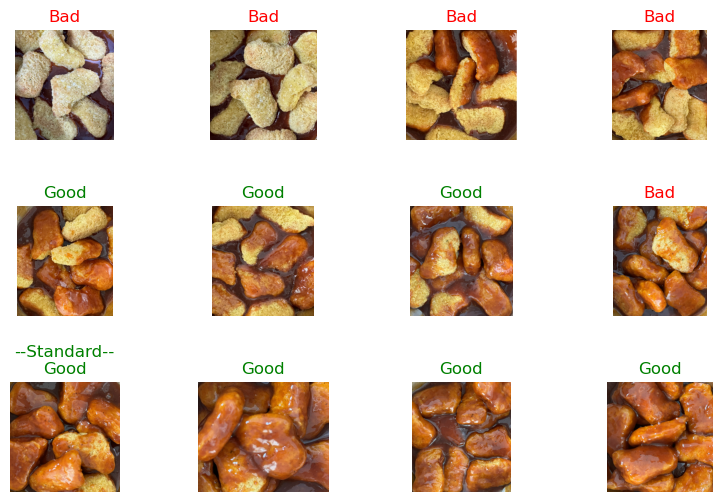

Text(0, 0.5, 'Entropy Standard Deviation')

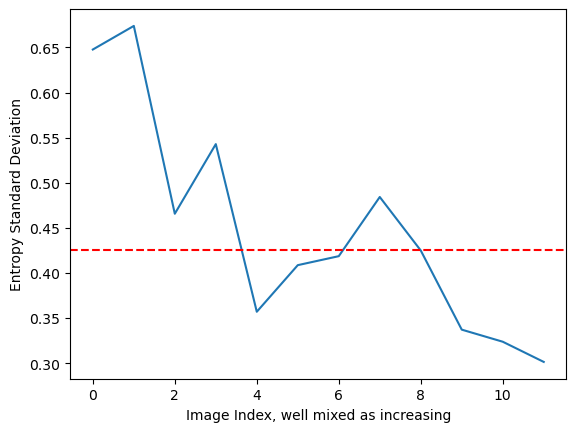

In [30]:
imgs = []
steps = 2
for i in range(0, 27, steps):
    inImg = cv2.imread('D:/ChickenImage/samples_made/%d.jpg'%(i+1), cv2.IMREAD_COLOR)
    if inImg is None:
        continue
    img = inImg.copy()
    imgs.append(img)
    
print(len(imgs))    

std = 8 #2, 5, 8, 9

ms = MixtureSystem('D:/ChickenImage/output1', tol=1.0)
target_img = cv2.imread('D:/ChickenImage/samples_made/70_test.png', cv2.IMREAD_COLOR)
ms.fit(imgs[std])

fig, axs = plt.subplots((len(imgs) + 3) // 4, 4 , figsize=(10, 6))
fig.subplots_adjust(wspace=0.1, hspace=0.6)

entropys = []
for i in range(((len(imgs) + 3) // 4) * 4):
    axs[i//4][i%4].axis('off')

for i, img in enumerate(imgs):
    axs[i//4][i%4].axis('off')
    ms.run(img)
    ms.evaluate()
    
    axs[i//4][i%4].imshow(ms.target_raw)
    
    if ms.result:
        goodbad = 'Good'
        c = 'g'
    else:
        goodbad = 'Bad'
        c = 'r'
    if i == std:
        axs[i//4][i%4].set_title('--Standard--\n%s'%goodbad, color=c)
    else:
        axs[i//4][i%4].set_title(goodbad, color=c)
        
    entropys.append(ms.target.std)
    


plt.show()

plt.plot(entropys)
plt.xlabel("Image Index, well mixed as increasing")
plt.axhline(y=ms.threshold, color='r', linestyle='--')
plt.ylabel("Entropy Standard Deviation")

<h2>Test 2</h2>

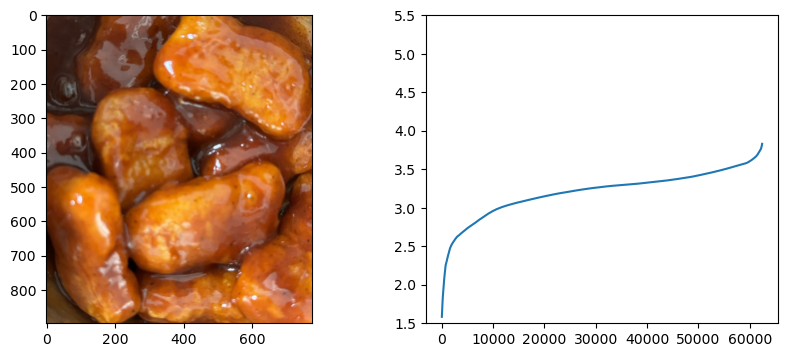

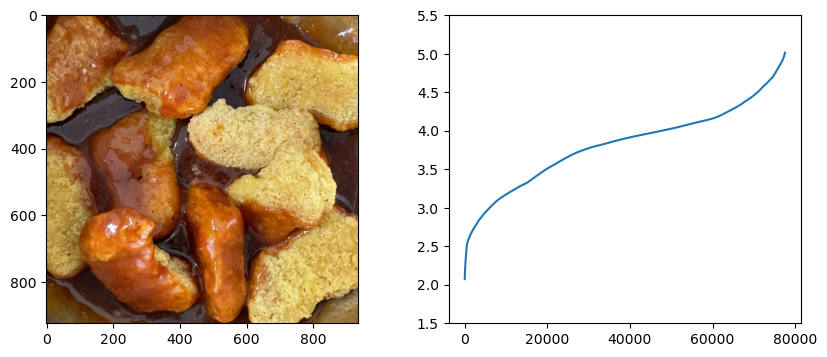

In [25]:
ms = MixtureSystem('D:/ChickenImage/output1', tol=1.0)

target_img = cv2.imread('D:/ChickenImage/samples_made/26.jpg', cv2.IMREAD_COLOR)
ms.fit(target_img)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[1].plot(np.sort(ms.base.entropy.reshape(1,-1)[0]))
axs[1].set_ylim([1.5, 5.5])
axs[0].imshow(ms.base_raw)
plt.show()

target_img = cv2.imread('D:/ChickenImage/samples_made/10.jpg', cv2.IMREAD_COLOR)
ms.fit(target_img)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[1].plot(np.sort(ms.base.entropy.reshape(1,-1)[0]))
axs[1].set_ylim([1.5, 5.5])
axs[0].imshow(ms.base_raw)
plt.show()

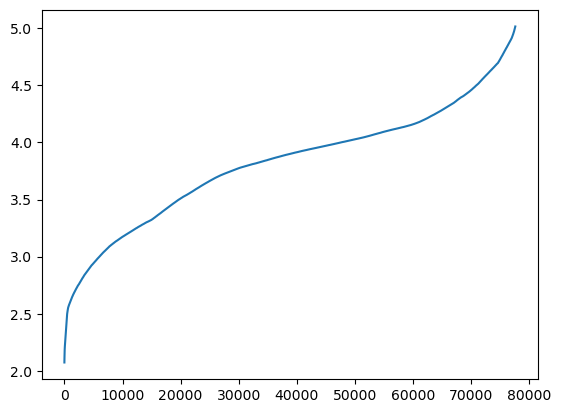

In [16]:
ms = MixtureSystem('D:/ChickenImage/output1', tol=1.0)
target_img = cv2.imread('D:/ChickenImage/samples_made/10.jpg', cv2.IMREAD_COLOR)

ms.fit(target_img)
plt.plot(np.sort(ms.base.entropy.reshape(1,-1)[0]))